In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
from orographicPrecipitation.precip_model_functions import retrieve_era5_pl,retrieve_era5_sfc


# Functions

In [2]:
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
ERA5M_PATH2 = "/global/project/projectdirs/m3310/wboos/era5monthly/"

boxNH = [[-100, -70, 12 , 20],
         [-80 , -60, 8  , 16],
         [70  , 90 , 2  , 18],
         [100 , 120, 8  , 20],
         [118 , 140, 4  , 20],
         [100 , 110, 0  , 12],
        ]

boxSH = [[20  , 50 , -20, 0 ],
         [-60 , -30, -20, 0 ],
        ]

boxNH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxNH]
boxSH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxSH]

namesNH = ["Central America",
           "Venezuela",
           "South India / Sri Lanka",
           "Vietnam / South China Sea",
           "Philippines",
           "Malaysia"
          ]
namesSH = ["Tanzania",
           "NorthEast Brazil"
          ]

In [10]:
#Data extraction from ERA5
era5yrs = list(range(1979,2019))

def retrieve_era5(year,varid):
    """gather an ERA5 monthly mean variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    era5var = xr.open_dataset(glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0])
    varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    
    return era5var[varname]

def retrieve_era5_month(month,varid):
    varlist = []
    for year in era5yrs:
        var = retrieve_era5(year,varid)
        varmonth = var.sel(time="%s-%s"%(year,month))
        varlist.append(varmonth)
    return xr.concat(varlist, "time")

#climatological mean computation
def climat_mean(month,varid):
    """Compute the climatological mean of a variable specified by 'varid', for a specific month
        - month : str, eg. '05' for May
        - varid : str, eg. "128_130_t" for temperature
    """    
    return retrieve_era5_month(month,varid).mean("time")


def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    
    return region_mean


In [32]:
def plot_skewT(fig,subplot,temp,rh,legend=""):
    """Plot a skew-T diagram given two arrays, column temperature in K and relative humidity in %
    The first array must have pressure levels as a dimension"""
    p = np.array(temp.level)* units.hPa
    T = (np.array(temp)-273.15) * units.degC
    r = np.array(rh)/100
    Td = mpcalc.dewpoint_from_relative_humidity(T,r)
    
    skew = SkewT(fig,subplot=subplot, rotation=45)
    
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot.
    skew.plot(p, T, 'r',label='ERA-5 temperature (°C)')
    skew.plot(p, Td, 'g',label='ERA-5 dew point (°C)')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    
    # Calculate LCL height and plot as black dot. 
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[-1], T[-1], Td[-1])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    
    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p[::-1], T[-1], Td[-1]).to('degC')[::-1]
    skew.plot(p, prof, 'k', linewidth=2,label='ERA-5 parcel profile (°C)')
    
    # Shade areas of CAPE and CIN
    skew.shade_cin(p, T, prof)
    skew.shade_cape(p, T, prof)
    
    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    
    # Show the plot
    skew.ax.set_title("Skew T diagram - "+legend)
    plt.legend()

def plot_skewT2(fig,subplot,temp,rh,temp_d,rh_d,temp_w,rh_w):
    p = np.array(temp.level)* units.hPa
    T = (np.array(temp)-273.15) * units.degC
    r = np.array(rh)/100
    Td = mpcalc.dewpoint_from_relative_humidity(T,r)
    
    T_d = (np.array(temp_d)-273.15) * units.degC
    Td_d = mpcalc.dewpoint_from_relative_humidity(T_d,np.array(rh_d)/100)

    T_w = (np.array(temp_w)-273.15) * units.degC
    Td_w = mpcalc.dewpoint_from_relative_humidity(T_w,np.array(rh_w)/100)
    
    skew = SkewT(fig,subplot=subplot, rotation=45)
    
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot.
    skew.plot(p, T, color='orange',label='ERA-5 temperature (°C) | mean')
    skew.plot(p, T_d, 'r',label='ERA-5 temperature (°C) | dry')
    skew.plot(p, T_w, color = 'gold',label='ERA-5 temperature (°C) | wet')
    
    skew.plot(p, Td_d, color='mediumblue',label='ERA-5 dew point  (°C) | dry')
    skew.plot(p, Td,   color='forestgreen',label='ERA-5 dew point  (°C) | mean')
    skew.plot(p, Td_w, color='lawngreen',label='ERA-5 dew point  (°C) | wet')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    
    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    #skew.plot_mixing_lines()
    
    # Show the plot
    plt.legend()

# Masks, data

In [3]:
def slide_coord(mask):
    """Switch the longitude coord from (-180,180) to (0,360) 
    and change coordinate names from 'LAT1','LON1' to 'latitude' and 'longitude'"""
    mask0=mask.copy()
    mask0.coords['longitude'] = mask0.coords['LON1']%360
    mask1 = mask0.swap_dims({'LON1': 'longitude'}).rename({'LAT1': 'latitude'})

    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(mask1["longitude"].values)}
    mask1 = mask1.isel(**sort_inds)
    return mask1

#masks = xr.open_dataset("/global/cscratch1/sd/qnicolas/masks/winter_rainfall_masks.nc")
#/!\ temporary change for access on Spin
masks = xr.open_dataset("winter_rainfall_masks.nc")
trmm_nh_winter_mask = masks.TRMM_NH_WINTER_MASK.fillna(0.)
trmm_sh_winter_mask = masks.TRMM_SH_WINTER_MASK.fillna(0.)


## To be modified
REFERENCE_GRID = xr.open_dataset(ERA5M_PATH+"e5.moda.an.pl/e5.moda.an.pl.128_060_pv.ll025sc.1979010100_1979120100.nc").PV.sel(latitude=slice(50., -50.)).isel(time=0) #to get the era5 grid

trmm_nh_winter_mask1 = (slide_coord(trmm_nh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_sh_winter_mask1 = (slide_coord(trmm_sh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_nh_winter_mask2 = slide_coord(trmm_nh_winter_mask)
trmm_sh_winter_mask2 = slide_coord(trmm_sh_winter_mask)                     

In [38]:
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=landmask.interp_like(REFERENCE_GRID)


In [5]:
ghcn = xr.open_dataset("/global/cscratch1/sd/qnicolas/ghcn.precip.mon.total.nc",decode_times=False)
ghcn.coords['time'] = pd.to_datetime('1800-01-01') + pd.to_timedelta(np.array(ghcn.coords['time']),'d')
ghcn=ghcn.rename({'lat':'latitude','lon':'longitude'}).precip

In [7]:
# determine dry and wet years for each region,with ghcn
def timesel(year,month,targetmonth):
    return (year >= 1979) & (year < 2019) & (month == targetmonth)

ghcn_nov = ghcn.sel(time = timesel(ghcn['time.year'],ghcn['time.month'],11))
ghcn_may = ghcn.sel(time = timesel(ghcn['time.year'],ghcn['time.month'],5))

nwettest = int((2015-1979)/3);ndriest = nwettest
drywetyearsNH = []
for i,box in enumerate(boxNH1):
    ghcn_nov_box = np.array([region_mean2D(ghcn_nov.sel(latitude=slice(50., -50.),time=y),
                                           trmm_nh_winter_mask1.interp_like(ghcn_nov),box) for y in ghcn_nov.time])
    drywetyearsNH.append({"dry" : ghcn_nov.time[np.argpartition(ghcn_nov_box, ndriest)[:ndriest]], "wet" : ghcn_nov.time[np.argpartition(-ghcn_nov_box, nwettest)[:nwettest]]})

drywetyearsSH = []
for i,box in enumerate(boxSH1):
    ghcn_may_box = np.array([region_mean2D(ghcn_may.sel(latitude=slice(50., -50.),time=y),
                                           trmm_sh_winter_mask1.interp_like(ghcn_may),box) for y in ghcn_may.time])
    drywetyearsSH.append({"dry" : ghcn_may.time[np.argpartition(ghcn_may_box, ndriest)[:ndriest]], "wet" : ghcn_may.time[np.argpartition(-ghcn_may_box, nwettest)[:nwettest]]})
    

In [11]:
t=time.time()
all_tt_nov = retrieve_era5_month("11",'128_130_t' );all_tt_may = retrieve_era5_month("05",'128_130_t' )
all_rh_nov = retrieve_era5_month("11",'128_157_r' );all_rh_may = retrieve_era5_month("05",'128_157_r' )
print(time.time()-t)#5min

In [34]:
mean_tt_nov = all_tt_nov.mean("time");mean_tt_may = all_tt_may.mean("time")
mean_rh_nov = all_rh_nov.mean("time");mean_rh_may = all_rh_may.mean("time")

In [12]:
t=time.time()
ttNH = []; rhNH = []
for i,box in enumerate(boxNH1):
    ttNH.append({"dry" : all_tt_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_tt_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")})
    rhNH.append({"dry" : all_rh_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_rh_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")}) 

print(time.time()-t)

130.1266815662384


In [35]:
t=time.time()
ttSH = []; rhSH = []
for i,box in enumerate(boxSH1):
    ttSH.append({"dry" : all_tt_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_tt_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")})
    rhSH.append({"dry" : all_rh_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_rh_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")}) 

print(time.time()-t)

44.17158126831055


# Plotting

## Over land+ocean

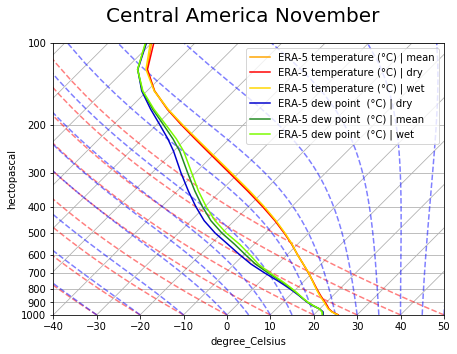

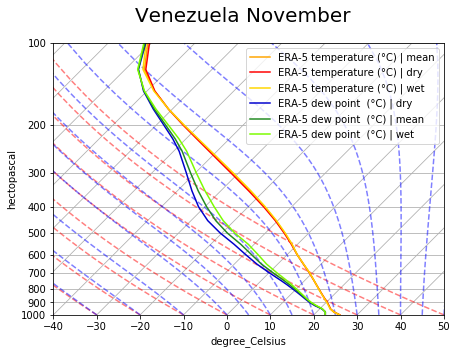

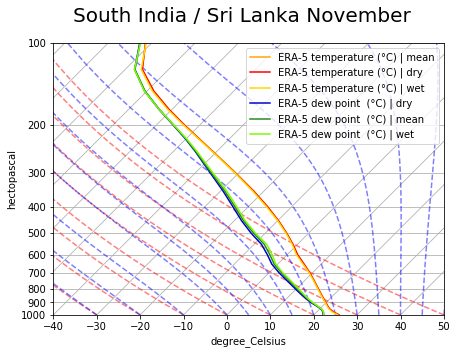

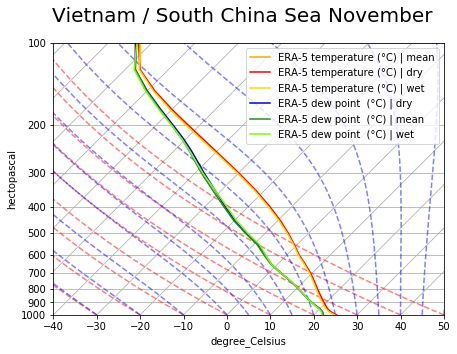

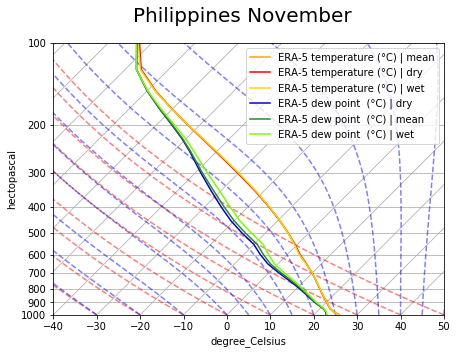

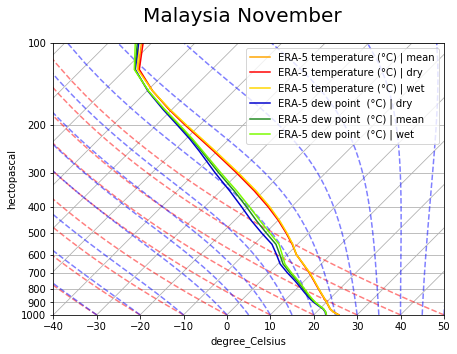

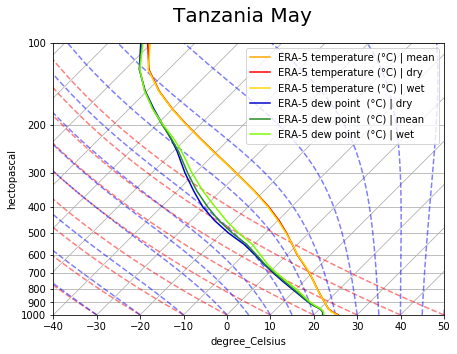

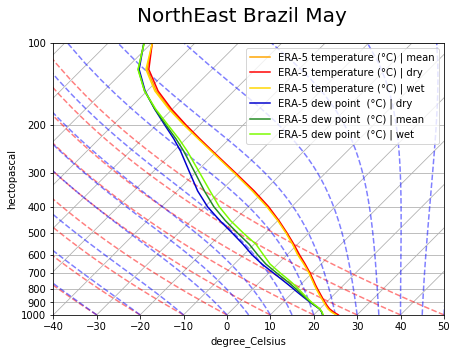

In [37]:
def skewt_drywet(boxes,maskk,mean_tt,mean_rh,tt_wd,rh_wd,month,names):
    for i,box in enumerate(boxes):
        #Mean state values
        tt = region_mean2D(mean_tt,maskk,box)
        rh = region_mean2D(mean_rh,maskk,box)
        
        #dry years values
        tt_d = region_mean2D(tt_wd[i]["dry"],maskk,box)
        rh_d = region_mean2D(rh_wd[i]["dry"],maskk,box)
    
        #wet years values
        tt_w = region_mean2D(tt_wd[i]["wet"],maskk,box)
        rh_w = region_mean2D(rh_wd[i]["wet"],maskk,box)
        
        #fig = plt.figure(figsize=(20,5))
        #plot_skewT(fig,131,tt_d,rh_d,legend="dry")
        #plot_skewT(fig,132,tt,rh,legend="mean")
        #plot_skewT(fig,133,tt_w,rh_w,legend="wet")
        
        fig = plt.figure(figsize=(7,5))
        plot_skewT2(fig,111,tt,rh,tt_d,rh_d,tt_w,rh_w)

        

        fig.suptitle(names[i]+" %s"%month,fontsize=20)

skewt_drywet(boxNH1,trmm_nh_winter_mask1,mean_tt_nov,mean_rh_nov,ttNH,rhNH,"November",namesNH)
skewt_drywet(boxSH1,trmm_sh_winter_mask1,mean_tt_may,mean_rh_may,ttSH,rhSH,"May",namesSH)

        

## Comparison with land only

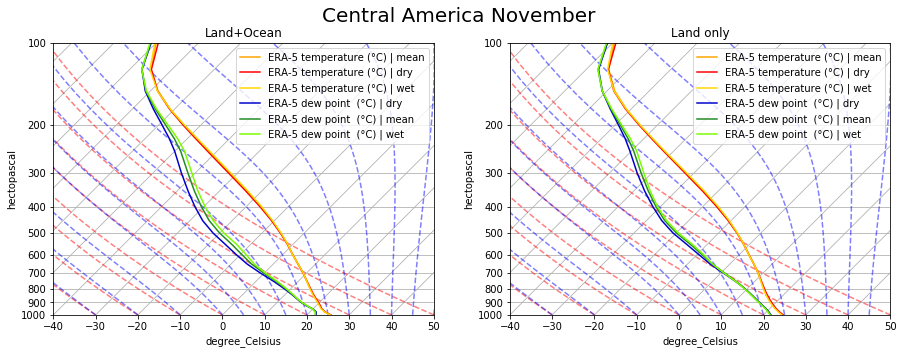

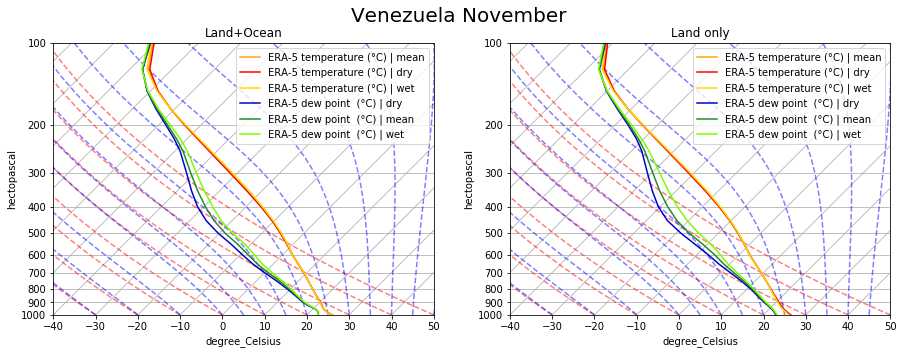

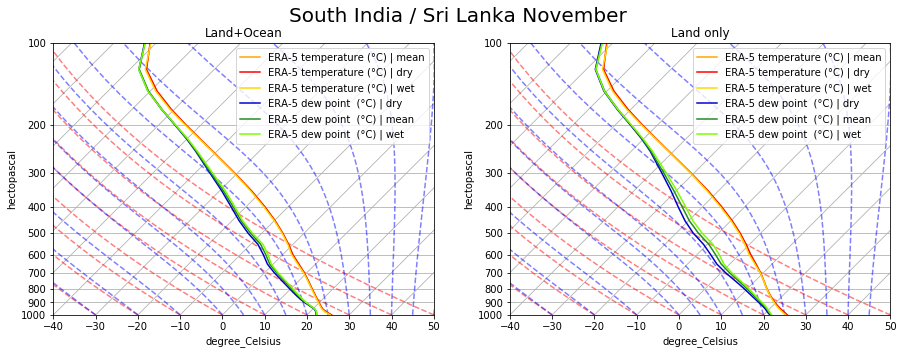

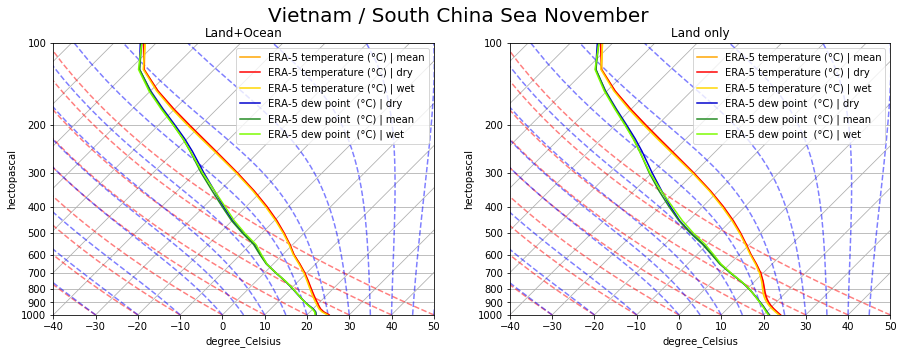

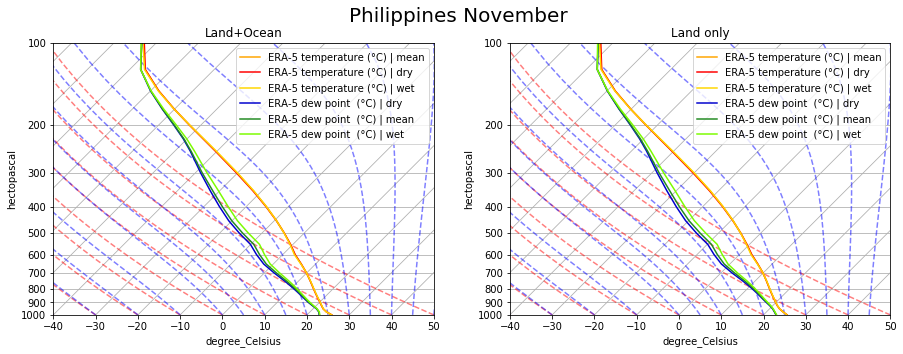

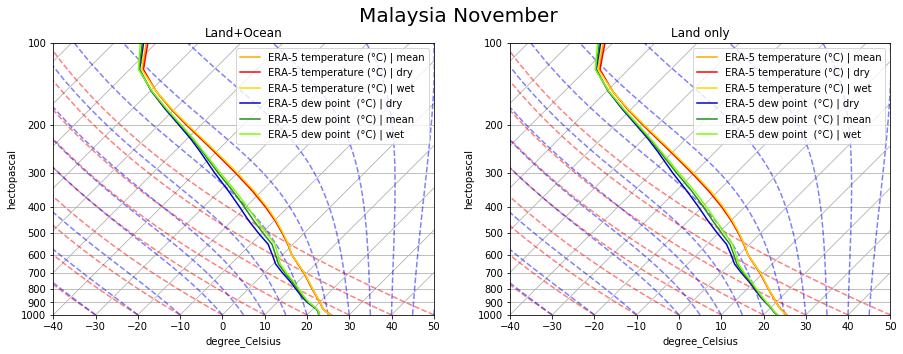

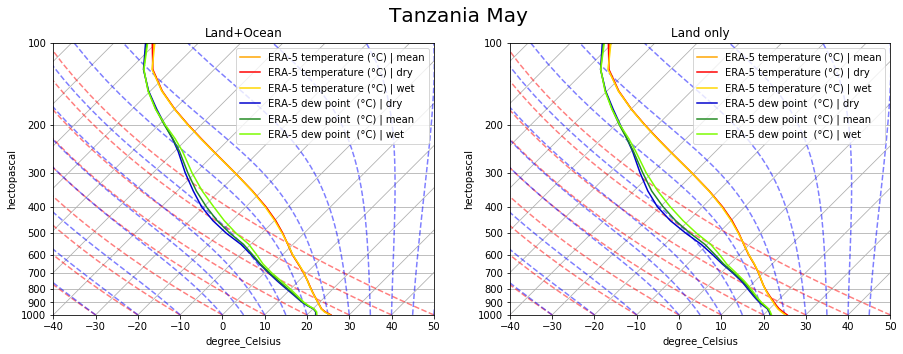

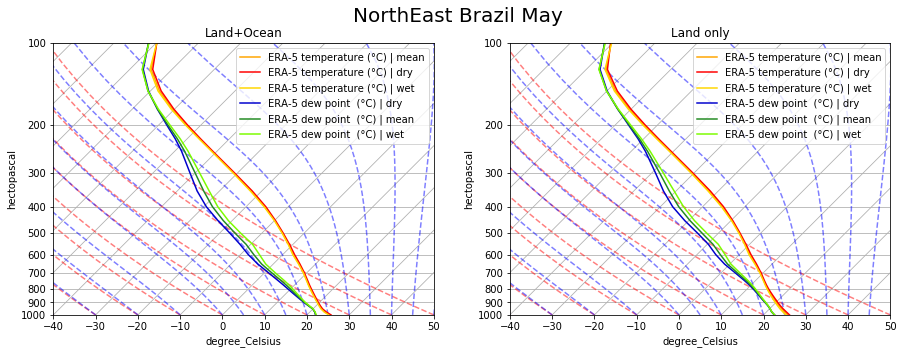

In [41]:
def skewt_drywet(boxes,maskk,maskkl,mean_tt,mean_rh,tt_wd,rh_wd,month,names):
    for i,box in enumerate(boxes):
        #Mean state values
        tt = region_mean2D(mean_tt,maskk,box)
        rh = region_mean2D(mean_rh,maskk,box)
        
        #dry years values
        tt_d = region_mean2D(tt_wd[i]["dry"],maskk,box)
        rh_d = region_mean2D(rh_wd[i]["dry"],maskk,box)
    
        #wet years values
        tt_w = region_mean2D(tt_wd[i]["wet"],maskk,box)
        rh_w = region_mean2D(rh_wd[i]["wet"],maskk,box)

        #Mean state values
        ttl = region_mean2D(mean_tt,maskkl,box)
        rhl = region_mean2D(mean_rh,maskkl,box)
        tt_dl = region_mean2D(tt_wd[i]["dry"],maskkl,box)
        rh_dl = region_mean2D(rh_wd[i]["dry"],maskkl,box)
        tt_wl = region_mean2D(tt_wd[i]["wet"],maskkl,box)
        rh_wl = region_mean2D(rh_wd[i]["wet"],maskkl,box)
        
        fig = plt.figure(figsize=(15,5))
        plot_skewT2(fig,121,tt,rh,tt_d,rh_d,tt_w,rh_w)
        plot_skewT2(fig,122,ttl,rhl,tt_dl,rh_dl,tt_wl,rh_wl)

        fig.axes[0].set_title("Land+Ocean")
        fig.axes[1].set_title("Land only")

        fig.suptitle(names[i]+" %s"%month,fontsize=20)

skewt_drywet(boxNH1,trmm_nh_winter_mask1,landmask50*trmm_nh_winter_mask1,mean_tt_nov,mean_rh_nov,ttNH,rhNH,"November",namesNH)
skewt_drywet(boxSH1,trmm_sh_winter_mask1,landmask50*trmm_sh_winter_mask1,mean_tt_may,mean_rh_may,ttSH,rhSH,"May",namesSH)

        